In [1]:
import os
import rpy2
import logging
import warnings
import anndata2ri
import pandas as pd
import scanpy as sc
import numpy as np
import decoupler as dc
import matplotlib.pyplot as plt
from gsva_prep import prep_gsva
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from functions import pathway_analyses
from sklearn.model_selection import train_test_split


In [2]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.5.0
anndata2ri                  1.1
appnope                     0.1.3
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.1
comm                        0.1.3
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
decoupler                   1.4.0
executing                   1.2.0
functions                   NA
google                      NA
gsva_prep                   NA
h5py                        3.9.0
igraph                      0.10.4
ipykernel                   6.23.2
ipywidgets                  8.0.6
jedi                        0.18.2
jinja2                      3.1.2
joblib                      1.2.0
kiwisolver                  1.4.4
leidenalg                   0.9.1
llvmlite                    0.39.1
louvain                     0.8.0
markupsafe 

In [3]:
%%R
suppressPackageStartupMessages({
    library(Matrix)
    library(viridis)
    library(harmony)
    library(ggpubr)
    library(tictoc)
    library(RColorBrewer)
    library(Hmisc)
    library(corrplot)
    library(grid)
    library(gridExtra)
    library(igraph)
    library(ggrepel)
    library(readxl)
    library(conflicted)
    library(dplyr)
    library(parallel)
    library(stringr)



    # single-cell analysis package
    library(Seurat)
    library(SingleCellExperiment)
    library(tidyr)
    library(readxl)
    library(GSA)
    library(limma)

    # plotting and data science packages
    library(tidyverse)
    library(cowplot)
    library(patchwork)
    library(ggplot2)

    # co-expression network analysis packages:
    library(WGCNA)
    library(hdWGCNA)

    # gene enrichment packages
    library(enrichR)
    library(GeneOverlap)
    library(GSEABase)
    library(GSVA) 

# needs to be run every time you start R and want to use %>%
})

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

# optionally enable multithreading
# enableWGCNAThreads(nThreads = 4)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In addition: Warning messages:
1: package ‘MatrixGenerics’ was built under R version 4.3.1 
2: package ‘S4Vectors’ was built under R version 4.3.1 
3: package ‘IRanges’ was built under R version 4.3.1 
4: package ‘GenomeInfoDb’ was built under R version 4.3.1 
5: package ‘AnnotationDbi’ was built under R version 4.3.1 
6: package ‘GSVA’ was built under R version 4.3.1 


# **Systematic differential analysis of pathway activity**

Pathway activity scores were computed in accordance with the overall protocol outlined in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w).

- Aggregate gene expression profiles into `pseudo-cells` or `pseudo-bulks` depending to the desired strategy in **[Gazestani. et. al. 2023](https://www.sciencedirect.com/science/article/pii/S0092867423008590?via%3Dihub)**

- Use GSVA to obtain pathway activity scores for pathways obtained from [**Gene Ontology biological processes (2021) edition**](https://maayanlab.cloud/Enrichr/#libraries).

- Perform differential pathway activity analysis using limma 


### **Data Prep Parameters**


- `metadata`: Path to metadata. It must include a `pathology.group` column with unique groups being `no`, `early`, and `late`.

- `map_meta`: Indicates if metadata mapping is required for `pathology.group`. If set to False, `pathology.group` must exist in `adata.obs`

- `test_names`: List of the different test names of interest.

- `save_prefix`: Preferred prefix for saving critical files. Ideally chosen to be in the format `{source name}_{brain region}`. e.g `mathys_pfc`

- `subject_id`: Column name for Subject/Patient ID in both metadata and `.obs`

In [4]:
save_prefix = 'seaad_mtg' # this takes the format '{StudyName}_{ThreeLetterAccronymForBrainRegion}'
cell_group = 'microglia'
cell_type_column = 'Subclass'
control_group = 'no'     # name of the control group in metadata 
factor = 'Continuous Pseudoprogression Score'  # pathology.group
factor = factor.replace(" ", "").replace("-", "")

subclass = {'excitatory': ['L5 IT', 'L2/3 IT', 'L4 IT', 'L6 IT', 'L6 IT Car3', 'L5/6 NP', 'L6b', 'L6 CT', 'L5 ET'],
            'inhibitory': ['Pvalb', 'Sst', 'Lamp5 Lhx6', 'Vip', 'Lamp5', 'Sncg', 'Chandelier', 'Sst Chodl', 'Pax6'],
            'astrocyte': ['Astrocyte'],
            'microglia': ['Microglia-PVM'],
            'opc': ['OPC'],
            'oligo': ['Oligodendrocyte'],
            'endo': ['Endothelial'],
            'vlmc': ['VLMC'],
            }

cell_supertype = subclass[cell_group][0]

map_meta = True


get_cell_types = False   # whether to reformat cell_type annotation

subject_ids_for_study = {'leng_sfg': 'PatientID',
                        'leng_etc': 'PatientID',
                        'seaad_mtg': 'Donor ID', 
                        'gazestani_pfc': 'individualID'}

subject_id = subject_ids_for_study[save_prefix]     # for leng this is `PatientID` for mathys is 'Subject', and allen is 'individualID'
metadata = f'../data/raw/{save_prefix}/{save_prefix}_metadata.csv' # Metatdata location
meta = pd.read_csv(metadata, encoding_errors='ignore')
test_names = ['early_vs_no', 'late_vs_early', 'late_vs_no', 'ad_vs_no'] # test categories


### **Load and Prep Data**

load the preprocessed and annotated data for differential pathway analysis.

Make sure the anndata has the count data in either `.layers` or in `.X`. if count data is not in `.layers` it will be assumed that `.X ` contains the counts

In [5]:
adata_annot = sc.read_h5ad(f'../data/raw/{save_prefix}/anndata/{cell_group}_raw_anndata.h5ad')
adata_annot.obs_names_make_unique()
adata_annot.var_names_make_unique()

if 'counts' not in adata_annot.layers.keys():
    print('"counts" not in layers...')
    print('analysis requires unnormalized count data...')
    print('fetching count data from "adata.X"...')
    adata_annot.layers['counts'] = adata_annot.X.copy()

else:
    adata_annot.X = adata_annot.layers['counts'].copy()

layer_keys = list(adata_annot.layers.keys())
for layer in layer_keys:
    if layer != 'counts':
        del adata_annot.layers[layer]

del adata_annot.obsm, adata_annot.varm, adata_annot.uns, adata_annot.obsp, adata_annot.X, adata_annot.var 


celltypes = list(adata_annot.obs[cell_type_column].unique())

# map the pathology group to teh subject id in .obs

meta = pd.read_csv(metadata, encoding_errors='ignore')
meta = meta.astype(str)
mapping = dict(zip(meta[subject_id], meta['pathology.group']))
adata_annot.obs[subject_id] = adata_annot.obs[subject_id].astype("category")
adata_annot.obs['pathology.group'] = adata_annot.obs[subject_id].map(mapping)


adata_annot = adata_annot[adata_annot.obs.Subclass == cell_supertype]
adata_annot = adata_annot[adata_annot.obs['Neurotypical reference'] == 'False']
adata_annot = adata_annot[adata_annot.obs['Severely Affected Donor'] == 'N']


adata_annot

View of AnnData object with n_obs × n_vars = 34803 × 36601
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA

### **Count Aggregation Parameters**

- `filter_genes`: Setermines if genes should be filtered using `gene_celltype_threshold` before DE tests.

- `pseudobulking_strategies`: Defines the pseudobulking strategy and includes options such as `network`, `random`, `smaller_network`, `standardbulk`, and `blanchardbulk`.

- `normalization_methods`: Specifies normalization methods for data, options are "TMM", "VST", "rmTop50", and "none" (default: "CPM").

- `gene_selection`: Required only if `pseudobulking_strategy=='metacell'`, indicating the gene selection method for setting up a Seurat object for WGCNA.

- `geneSet`: Required only if `pseudobulking_strategy=='metacell'` and `gene_selction='custom'`, specifying a custom gene set.

- `gene_celltype_threshold`: Determines the number of cells a gene must be expressed in.

- `pathway_gene_threshold`: Determines the number of genes that must be present in a pathway.

- `min_size_limit`: Specifies the minimum acceptable size of the pseudobulk data, with pseudobulks below this cell threshold excluded from the analysis.

In [6]:
filter_genes = "TRUE"
count_agg_strategy = 'network'    # options 'network', 'random', 'smaller_network', 'standardbulk', 'metacell', `blanchardbulk``
normalization_methods = ["CPM"]   # options: "TMM", "VST", "rmTop50", "none" default: "CPM"
gene_selection = 'fraction'       # Only required if `pseudobulking_strategy=='metacell'``. specifies the gene selection method when setting up seurat object for WGCNA. 
geneSet = ''                      # Only required if `pseudobulking_strategy=='metacell'`` and `gene_selction='custom'`
gene_celltype_threshold = 0.10    # determines number of cells the gene must be expressed in
pathway_gene_threshold = 0.33     # determines number of genes that must be present in that pathway
min_size_limit = 30               # min_size_limit: the minimum acceptable size of the pseudobulk data.
                                  # min_size_limit: pseudobulks with cells less than this threshold are excluded from the analysis 

### **Differential Pathway Activity Testsing Parameters:**

The primary differential pathway activity analaysis:

- `covariates`: List of covariates, including (`including pathology.group`, ) e.g `Sex`, `Sample Batch`, and `Age`. Covariates can be factors that are not of primary interest but might have an effect on the pathological status. For no additional confounders, set `covaraites = ['pathology.group']`.

    - `Note`: Ensure that continuous covariates are similarly scaled.

    - `Standardization`: Maintain uniformity in categorical data. E.g., Avoid having 'M', 'Male', and 'male' in the same dataset.

    - `Impact Assessment`: Regularly assess the impact of the covariates included the differential expression (DE) results by excluding them one by one and checking how the DE patterns change. If a covariate unduly influences results, exercise caution.

- `random_effect`: Column name(s) for the random effect(s) (in this case `subject_id` or `Sample_batch`). For pseudobulk data, set do not include `subject_id`.

In [7]:
######################### Differential expression arguments #########################

random_effect = "".join(subject_id.split(" "))      # Technical covariate to be included as random effect not of interest (regressed out by duplicatecorrection)
duplicate_correction = 'False'                      # whether to run duplicate corretion in Limma to block out technical_covariate
jack_knifing = False                                # False if adata_annot.obs[subject_id].nunique()<=10 else True

covaraites_for_study = {'leng_sfg': ['pathology.group', 'QC_Gene_unique_log', 'QC_MT.pct'],  # ['ageDeath.cat',],
                        'leng_etc': ['pathology.group', 'QC_Gene_unique_log', 'QC_MT.pct'],  # ['ageDeath.cat',]
                        'seaad_mtg': ['Continuous Pseudo-progression Score', 'Age at Death', 'Gender', 'QC_Gene_unique_log', 'QC_MT.pct'],
                        'gazestani_pfc': ['pathology.group', 'anno_sex', 'anno_age', 'QC_Gene_unique_log', 'QC_MT.pct', ]}

numeric_covariates_for_study = {'gazestani_pfc': ['anno_age',],
                                'seaad_mtg': ['Age at Death'],
                                'leng_etc': 'None'}


covariates = covaraites_for_study[save_prefix]  # list of covariates to be accounted for in regression.True
numeric_covariates = numeric_covariates_for_study[save_prefix]


In [8]:

if " " in subject_id:
    subject_id2  = "".join(subject_id.split(" "))
    subject_id2 = subject_id2.replace("-", "")
    adata_annot.obs[subject_id2] = adata_annot.obs[subject_id].copy()
    meta.rename(columns={subject_id: subject_id2}, inplace=True)
    del adata_annot.obs[subject_id]
    subject_id = subject_id2
    
    
for col in adata_annot.obs.keys():
    if col not in covariates and col != cell_type_column and col!=subject_id:
            try:
                del adata_annot.obs[col]
            except KeyError:
                continue

for col in covariates:
    if " " in col:
        col2  = "".join(col.split(" "))
        col2 = col2.replace("-", "")
        adata_annot.obs.rename(columns={col: col2}, inplace=True)
        meta.rename(columns={col: col2}, inplace=True)
        covariates[covariates.index(col)] = col2
        
        if col in numeric_covariates:
            numeric_covariates[numeric_covariates.index(col)] = col2
    
adata_annot

AnnData object with n_obs × n_vars = 34803 × 36601
    obs: 'Gender', 'AgeatDeath', 'Subclass', 'ContinuousPseudoprogressionScore', 'DonorID'
    layers: 'counts'

### **Send parameters to R interface with rpy2**

In [9]:
%%R -i adata_annot -i subject_id -i cell_type_column -i cell_group -i geneSet -i gene_celltype_threshold -i celltypes -i test_names -i save_prefix -i gene_selection -i celltypes -i control_group -i metadata -i subject_id -i covariates -i random_effect -i min_size_limit -i count_agg_strategy -i numeric_covariates 

print(adata_annot)
print('loaded data into memory for recursive use')

class: SingleCellExperiment 
dim: 36601 34803 
metadata(0):
assays(1): counts
rownames(36601): MIR1302-2HG FAM138A ... AC007325.4 AC007325.2
rowData names(0):
colnames(34803): GATAGCTAGCTGACCC-L8TX_210107_01_H09-1142430361
  GTATTGGAGAAGCGCT-L8TX_210930_01_E03-1153814379 ...
  GTCTCACCACCAGCTG-L8TX_210506_01_D08-1153814226
  TGCTCCAGTTCAGTAC-L8TX_210402_01_H09-1153814176
colData names(5): Gender AgeatDeath Subclass
  ContinuousPseudoprogressionScore DonorID
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
[1] "loaded data into memory for recursive use"


# **Count Aggregation**

## **Standard Pseudobulk Approach**

To create pseudobulk data per donor and cell_type

### **Pseudo-bulk With Decoupler**

#### **Requied Parameters when using decoupler**


- `min_counts`: Filter to remove samples by a minimum number of summed counts in a sample-group pair when using standard pseudobulk method

- `min_count`: Minimum count requiered per gene for at least some samples.

- `min_total_count`: Minimum total count required per gene across all samples.

- `large_n`: Number of samples per group that is considered to be "large".
    
- `min_prop`: Minimum proportion of samples in the smallest group that express the gene.

In [10]:
# Get pseudo-bulk profile

min_counts = 1000       #    Filter to remove samples by a minimum number of summed counts in a sample-group pair when using standard pseudobulk method
min_count = 10          #    Minimum count requiered per gene for at least some samples.
min_total_count = 15    #    Minimum total count required per gene across all samples.
large_n = 1             #    Number of samples per group that is considered to be "large".
min_prop = 1            #    Minimum proportion of samples in the smallest group that express the gene.

if count_agg_strategy == 'standardbulk':
    
    pdata = dc.get_pseudobulk(
        adata_annot,
        sample_col=subject_id,
        groups_col=cell_type_column,
        layer='counts',
        mode='sum',
        min_cells=min_size_limit, 
        min_counts=min_counts,
    )

    # Sample-cell-type QC visualization
    dc.plot_psbulk_samples(pdata, 
                           groupby=[subject_id, cell_type_column], 
                           figsize=(12, 6))
    
    summed_counts_per_celltype = {}
    expressed_genes_per_celltype = {}

    fig, axs = plt.subplots(ncols=5, nrows=len(pdata.obs[cell_type_column].unique())//5+1, figsize=(14, 8))
    axs = axs.flatten()
    for i, cell_type in enumerate(pdata.obs[cell_type_column].unique()):
        summed_counts_per_celltype[cell_type] = pdata[pdata.obs[cell_type_column]==cell_type].copy()
        
        # gene QC visualization

        dc.plot_filter_by_expr(summed_counts_per_celltype[cell_type], 
                               group='pathology.group', 
                               min_count=min_count,
                               min_total_count=min_total_count, 
                               large_n=large_n, 
                               min_prop=min_prop, 
                               ax=axs[i],
                               )
        
        axs[i].set_title(cell_type)

        
        expressed_genes_per_celltype[cell_type] = dc.filter_by_expr(summed_counts_per_celltype[cell_type],
                                                                    group='pathology.group', 
                                                                    min_count=min_count,
                                                                    min_total_count=min_total_count, 
                                                                    large_n=large_n, 
                                                                    min_prop=min_prop)
    plt.show()


In [11]:
# convert nested list of Seurat object into Rpy2 object 

if count_agg_strategy == 'standardbulk':
    summed_counts_per_celltype =  robjects.ListVector( {
                                                        cell_type: summed_counts_per_celltype[cell_type]
                                                    
                                                        for cell_type in summed_counts_per_celltype.keys()
                                                        }
                                                    )

    expressed_genes_per_celltype =  robjects.ListVector( {
                                                        cell_type: expressed_genes_per_celltype[cell_type]
                                                    
                                                        for cell_type in expressed_genes_per_celltype.keys()
                                                        }
                                                    )
else:
    summed_counts_per_celltype = 'NULL'
    expressed_genes_per_celltype = 'NULL'

In [12]:
%%R -i summed_counts_per_celltype -i expressed_genes_per_celltype

if (summed_counts_per_celltype == 'NULL'){
    print('Pseudobulk method not implemented.')
} else {
    print('done')
}

[1] "Pseudobulk method not implemented."


### **Pseuobulking With Strategy From [Joel W. Blanchard1](https://doi.org/10.1038/s41586-022-05439-w)**

In [13]:
%%R

if (count_agg_strategy == 'blanchardbulk'){
    
    conflicts_prefer(base::unname)
    
    source('../scripts/functions/qc_and_annotation_aux_functions.r')

    library(SingleCellExperiment)
    library(Matrix)
    library(tidyr)

    sce <- adata_annot

    # Update sce with QC_Gene_total_count and QC_Gene_unique_count
    for (id in unique(colData(sce)$subject_id)){
        mask <- colData(sce)[, subject_id] == id
        QC_Gene_total_count <- apply(counts(sce[, mask]), 1, sum)
        
        sce$QC_Gene_total_count[mask] <- sum(QC_Gene_total_count)
        sce$QC_Gene_unique_count[mask] <- sum(QC_Gene_total_count != 0)
        
        sce$QC_Gene_total_log[mask] <- log2(sce$QC_Gene_total_count[mask])
        sce$QC_Gene_unique_log[mask] <- log2(sce$QC_Gene_unique_count[mask])
    }

    print('normalizing counts')
    sce = normalize.default(sce)

    # standardize subject IDs
    meta = colData(sce)
    meta[, subject_id] <- gsub("\\.", "_", meta[, subject_id])
    cell_labels = rownames(meta)

    # use matrix multiplication to summarize (sum) across counts per cell (including all individuals)
    print('sum counts by individual')
    labels = as.data.frame(as.character(interaction(meta[, cell_type_column], meta[, subject_id])))
    summed_logcounts_cellxind = sum_counts(logcounts(sce), labels, cell_labels)
    
    # get averages corresponding to both count matrices
    avs_logcounts_cellxind = t(apply(summed_logcounts_cellxind$summed_counts, 1, function(x){x/summed_logcounts_cellxind$ncells}))

    # split the averages by celltype
    x = (strsplit(colnames(avs_logcounts_cellxind), '[.]'))
    celltype = unlist(lapply(1:length(x), function(i) x[[i]][[1]]))
    individual = unlist(lapply(1:length(x), function(i) x[[i]][[2]]))
    celltype_unique = unique(celltype)

    avs_by_ind_out = list()
    summed_counts_per_celltype = list()
    expressed_genes_per_celltype = list()

    for(i in celltype_unique){

        index = celltype==i
        df = avs_logcounts_cellxind[, index]
        colnames(df) = individual[index]
        avs_by_ind_out[[i]] = df

        # create SingleCellExperiment object for summed counts
        summed_counts_per_celltype[[i]] = SingleCellExperiment(assays = list(logcounts = as.matrix(df)))
        rownames(colData(summed_counts_per_celltype[[i]])) = colnames(df)
        
        metadata <- meta[!duplicated(meta[, subject_id]), ]
        colData(summed_counts_per_celltype[[i]]) <- merge(colData(summed_counts_per_celltype[[i]]), 
                                                    metadata, 
                                                    by = NULL,
                                                    by.x = "row.names",
                                                    by.y = subject_id, 
                                                    all.x = TRUE)

        rownames(rowData(summed_counts_per_celltype[[i]])) <- rownames(df)  

        colData(summed_counts_per_celltype[[i]])[, subject_id] = colData(summed_counts_per_celltype[[i]])$Row.names
        
        # in how many cells per celltype is each gene detected?
        print('getting nonzero counts')

        mask <- colData(sce)[, cell_type_column] == i
        sce_temp <- sce[, mask]
        meta_temp <- as.data.frame(colData(sce_temp)[, cell_type_column])

        counts_nonzero = counts(sce_temp)>0
        
        # determine expressed genes based on threshold
        detected_genes_cell = sum_counts(counts_nonzero, label = meta_temp, cell_labels)
        fraction_detected_genes_cell = t(apply(detected_genes_cell$summed_counts, 1, function(x){x/detected_genes_cell$ncells}))

        # get expression list
        fraction_detected_genes_cell_binary = fraction_detected_genes_cell>gene_celltype_threshold
        genes = rownames(fraction_detected_genes_cell)
        expressed = lapply(colnames(fraction_detected_genes_cell_binary), function(x) genes[unname(fraction_detected_genes_cell_binary[,x])])
        names(expressed) = colnames(fraction_detected_genes_cell_binary)

        expressed_genes_per_celltype[[i]] <- names(expressed)
            
    }

}

## **Pseudocell approach [Gazestani. et. al. 2023](https://www.sciencedirect.com/science/article/pii/S0092867423008590?via%3Dihub)**

### **Pseudocell construction** 


Existing pathway enrichment techniques, initially designed for bulk RNA-seq data, typically employ either cell-based or pseudobulk-based approaches. While cell-based methods are time-consuming and sensitive to single-cell data dropouts, pseudobulk methods, which aggregate cell expressions into a single sample, address these issues but may lead to a loss of statistical power, neglecting variations in confidence levels between individuals with different cell-type sampling sizes.

To address these challenges pseudocell/metacell methods have been introduced this method lies between the cell-based and pseudobulk-based approaches, so it can take advantage of each method while remedying the issues attributed to them.

According to **[Gazestani. et. al. 2023](https://www.sciencedirect.com/science/article/pii/S0092867423008590?via%3Dihub)**, we first aggregate the raw UMI count of, on average, every 30 cells per subject and cell type. 

We construct one pseudocell for cell types that have between `15 to 45 cells in a donor` and exclude cell types that had less than `15 cells`. This pseudocell-based analysis reduces the impact of dropout and technical variability, while ameliorating low statistical power and high variation in sample size issues attributed to the pseudobulk approaches. 

**[Gazestani. et. al. 2023](https://www.sciencedirect.com/science/article/pii/S0092867423008590?via%3Dihub)**, provide functions:

- `To generate pseudocells that are composed of, on average, 20 cells or higher. This function can also generate pseudobulk samples.`

- `To generate pseudocells that are on average composed of 10 cells`

### **Available Aggregration Methods**


1. #### **Pseudocells from low-dim network embedding**

The main arguments for running the function:

- `parsing.col.names`: a vector of column names to be used to parse the data. Usually the columns related to the donor id and the cell type annotation (see above figure).

- `pseudocell.size`: the average size of pseudcoells. If NULL, generates pseudobulk data.

- `inputExpData`: Input single cell data object in format.

- `min_size_limit`: minimum acceptable size of the pseudocells. usually 10 or 15.

- `inputPhenoData`: the meta data on the cells that matches in order with the input PC space to use to create the similarity network. It's highly recommended to be used if. defualt: NULL.

- `nPCs`: Number of pcs to use to create the similarity network. Used only if human or mouse

- `rand_pseudobulk_mod`: To randomly assign cells to pseudocells in each cell type from each individual; or create a similarity network between these cells and use that similarity net to group cells with highly similar expression patterns to each other. `default: TRUE, but Here we set to FALSE``

The authors reiterate that it's highly recommended to provide if the function will generate the embedding for each cell type in each individual. it's possible that such embedding is driven by the quality of the cells in the group as opposed to biological variation, and hence quality of the pseudocells and inference on them would be limited.


2. #### **Pseudocells with random cell assignment**

Alternatively, we can create pseudocells using a method that randomly assign cells to pseudocells in each cell type from each individual by setting `rand_pseudobulk_mod=TRUE`. Rather than the previous method which creates a similarity network between these cells and uses that similarity network to group cells with highly similar expression patterns to each other.


3. #### **Pseudocells with smaller size**

We can also generate pseudocells using that allows us to have pseudocells of smaller size. The main arguments for this function:

- `inputExpData`: Input single cell data object in SingleCellExperiment format

- `embeddings`: Input PC space to use to create the similarity network. It can't be set to NULL

- `pseudobulk_split_col`: The column name to parse the single cell data.

- `min_dataset_size`: Minimum number of acceptable pseudocell size. default: 4.


#### **Gene Filtering**

We employ a rigorous filtering strategy to focus on biologically relevant gene programs. 

Genes were initially filtered based on their expression across samples, with those exhibiting low expression levels in more than 99% of the dataset excluded. 

- First, a counts-per-million (CPM) threshold was applied, retaining genes with CPM values surpassing the higher of 1% of the total samples or the minimum between 15 and one-third of the total samples. This strategy aimed to ensure the inclusion of genes with sufficient expression depth and magnitude. 

Moreover, to enhance the specificity of the retained genes, we implement a secondary filtering step based on individual sample expression. 

- Genes with lower than a count of 1 between maximum of 1% of the total samples or the minimum between 10 and one-third of the total samples were excluded. This approach, which includes both global and sample-specific considerations, facilitates the identification of a robust set of genes for downstream analysis.

In [14]:
############## PARAMETERS FOR NETWORK AND RANDOM #####################

pseudocell_size = 30    # the average size of pseudcoells. If NULL, generates pseudobulk data.
nPCs = 30               # Number of pcs to use to create the similarity network. Used only if human or mouse
organism = 'Human' 

############### PARAMETERS FOR 'SMALL NETWORK' #####################

pseudobulk_split_col = "lib_anno"
min_dataset_size = 4 

In [27]:
%%R -i organism -i nPCs -i pseudocell_size -i pseudobulk_split_col -i min_dataset_size

  
library(scuttle)
library(Matrix)
library(ensembldb)
library(EnsDb.Hsapiens.v86)

conflicts_prefer(GSEABase::setdiff)
conflicts_prefer(SingleCellExperiment::counts)


source("../scripts/functions/deg_functions/sconline_code.R")

# generating the embedding space

exp_seurat = .extraExport2SeuratFn(adata_annot) %>%
Seurat::NormalizeData() %>%
    FindVariableFeatures() %>% 
    ScaleData() %>% 
    RunPCA(verbose=F)

embedding_data = exp_seurat@reductions$pca@cell.embeddings[,1:30]
  
if (count_agg_strategy == 'network'){

  # generating the pseudocells
    
  # Function adds/modifies three annotation columns: pseuodcell_size, QC_Gene_total_count, QC_Gene_unique_count
  # QC_Gene_total_count: equivalant to nUMI for the pseudobulk samples
  # QC_Gene_unique_count: equivalant to nGene for the pseudobulk samples
  # use scale(tst$QC_Gene_total_count) and scale(tst$pseudocell_size) as additional covariates for the DE analysis

  res = suppressWarnings(.sconline.PseudobulkGeneration(argList = NULL, 
                                  # The columns in the pheonData that will be used to parse the expression data 
                                  # and generate the pseudocell/pseudobulk data
                                    parsing.col.names = c(subject_id, cell_type_column), 
                                  # average pseudocell size.
                                    pseudocell.size = pseudocell_size,
                                    inputExpData = adata_annot,
                                  # minimum acceptable size (ie, #cells) for each pseudobulk
                                    min_size_limit = min_size_limit,
                                  # in case we want to run the function outside sconline space
                                    inputPhenoData = as.data.frame(colData(adata_annot)),
                                  # the embedding space to be used for the generation of the pseudobulk.
                                  # only needed when pseudocell.size is not null
                                    inputEmbedding = embedding_data, 
                                  # the dimension of the embedding space for the construction of pseudobulk data
                                    nPCs = nPCs, 
                                    ncores = 1,
                                    rand_pseudobulk_mod = F,
                                  # used to identify and estimate Mitochondrial Genes
                                    organism = organism))
                                    
  res$QC_Gene_total_log=log2(res$QC_Gene_total_count)
  res$QC_Gene_unique_log=log2(res$QC_Gene_unique_count)
  
  summed_counts_per_celltype <- lapply(unique(colData(res)[, cell_type_column]), function(cell_type) res[, colData(res)[, cell_type_column] == cell_type,])
  names(summed_counts_per_celltype) <- unique(colData(res)[, cell_type_column])

} else  if (count_agg_strategy == 'random'){

  res = suppressWarnings(.sconline.PseudobulkGeneration(argList=NULL, 
                                  # The columns in the pheonData that will be used to parse the expression data 
                                  # and generate the pseudocell/pseudobulk data
                                    parsing.col.names = c(subject_id, cell_type_column), 
                                  # average pseudocell size.
                                    pseudocell.size = pseudocell_size,
                                    inputExpData = adata_annot,
                                  # minimum acceptable size (ie, #cells) for each pseudobul
                                    min_size_limit = min_size_limit,
                                  # in case we want to run the function outside sconline space
                                    inputPhenoData = as.data.frame(colData(adata_annot)),
                                    ncores = 1,
                                    rand_pseudobulk_mod = T,
                                  # used to identify and estimate Mitochondrial Genes
                                    organism = organism))

  res$QC_Gene_total_log=log2(res$QC_Gene_total_count)
  res$QC_Gene_unique_log=log2(res$QC_Gene_unique_count)


  summed_counts_per_celltype <- lapply(unique(colData(res)[, cell_type_column]), function(cell_type) res[, colData(res)[, cell_type_column] == cell_type,])
  names(summed_counts_per_celltype) <- unique(colData(res)[, cell_type_column])      
                                
}  else if (count_agg_strategy == 'pseudobulk'){

  res = suppressWarnings(.sconline.PseudobulkGeneration(argList = NULL, 
                                  # The columns in the pheonData that will be used to parse the expression data 
                                  # and generate the pseudocell/pseudobulk data
                                    parsing.col.names = c(subject_id, cell_type_column),  
                                  # average pseudocell size.
                                    pseudocell.size = NULL,
                                    inputExpData = adata_annot,
                                  # minimum acceptable size (ie, #cells) for each pseudobul
                                    min_size_limit = min_size_limit,
                                  # in case we want to run the function outside sconline space
                                    inputPhenoData = as.data.frame(colData(adata_annot)),
                                  # the embedding space to be used for the generation of the pseudobulk.
                                  # only needed when pseudocell.size is not null
                                    inputEmbedding = NULL, 
                                  # the dimension of the embedding space for the construction of pseudobulk data
                                    nPCs = NULL, 
                                    ncores = 1,
                                    rand_pseudobulk_mod = F,
                                    organism = organism))

  res$QC_Gene_total_log=log2(res$QC_Gene_total_count)
  res$QC_Gene_unique_log=log2(res$QC_Gene_unique_count)

  summed_counts_per_celltype <- lapply(unique(colData(res)[, cell_type_column]), function(cell_type) res[, colData(res)[, cell_type_column] == cell_type,])
  names(summed_counts_per_celltype) <- unique(colData(res)[, cell_type_column])  

} else  if (count_agg_strategy == 'smaller_network') {   

  adata_annot$lib_anno = paste0(adata_annot[[subject_id]], "_", adata_annot[[cell_type_column]])

  # creates pseudobulk samples of median size 10
  res = .sconline.Pseudobulk10(inputExpData=adata_annot,
                                      embeddings = embedding_data,
                                      pseudobulk_split_col = "lib_anno",
                                      min_dataset_size = min_dataset_siz,
                                      organism = organism)   

  res$QC_Gene_total_log=log2(res$QC_Gene_total_count)
  res$QC_Gene_unique_log=log2(res$QC_Gene_unique_count)

  summed_counts_per_celltype <- lapply(unique(colData(res)[, cell_type_column]), function(cell_type) res[, colData(res)[, cell_type_column] == cell_type,])
  names(summed_counts_per_celltype) <- unique(colData(res)[, cell_type_column])  

} else {

  summed_counts_per_celltype <- NULL
  names(summed_counts_per_celltype) <- NULL
}

[conflicted] Removing existing preference.
[conflicted] Will prefer GSEABase::setdiff over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer SingleCellExperiment::counts over any other package.
Main Functions:
.myRead10X()
.myRead10X_h5()
.myLigerToExpSet()
.mycBindFn()
.myExpSetCreatorFn()
.myIntegrative_oneline()
.myFindAllMarkers()
.myAnnotateFn()
.my2dPlot()
.myPseudoCellfn_v2()
.myLabelTransfer_harmony()
.myLabelTransfer_liger()
.myMapToHuman()
.myRiverPlotFn()
.myClusteringOptimizerFn()
.myMarkerBasedAnalysisFn()
.mycellAssignHeatmap()
.myMetaMarkerFn()
.myFindNeighbors()
.myVlnPlot()
.myFeaturePlot()
.myheatmap.3()
.myEvalMarkers()
.myReadGMT()
.mySplitObject()
.myRTNgsea(two-sided GSEA implementation)
[1] "batch information is in the anno_batch variable"
[1] "Number of MT genes in the dataset: 13 / 13"


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |======================================================================| 100%


Filter genes and perform log normalization

In [28]:
%%R

conflicts_prefer(base::intersect)

if (count_agg_strategy != 'standardbulk') {
    expressed_genes_per_celltype = list()
    for (cell_type in names(summed_counts_per_celltype)) {
        
        # Apply gene expression filtering for each cell type
        res <- tryCatch(
        {
            .sconline.FilterGenesByExpr(summed_counts_per_celltype[[cell_type]],
                                        raw_sce = adata_annot[, colData(adata_annot)[, cell_type_column] == cell_type],
                                        threshold = gene_celltype_threshold,
                                        TMMnorm = TRUE,
                                        quantile.norm = FALSE,
                                        prior.count = 0.25)
        },
        error = function(e) {
            cat(cell_type, ": An error occurred", conditionMessage(e), "\n")
            return(NULL)
        })

        if (!is.null(res)){
        
            # Subset the counts data to include only selected genes
            summed_counts_per_celltype[[cell_type]] <- summed_counts_per_celltype[[cell_type]][rownames(res$E), ]
            expressed_genes_per_celltype[[cell_type]] <- as.vector(rownames(res$E))

            # Update logcounts assay with the filtered expression values
            assays(summed_counts_per_celltype[[cell_type]])[["logcounts"]] <- res$E
            
        }else{
            summed_counts_per_celltype[[cell_type]] <- NULL
            expressed_genes_per_celltype[[cell_type]] <- NULL
        }
    }
} else if (count_agg_strategy == 'standardbulk'){

    for (cell_type in names(summed_counts_per_celltype)) {
        
        inputExpData <-  summed_counts_per_celltype[[cell_type]]
        tmpexp <- counts(inputExpData)[keep, ]
        dge <- DGEList(tmpexp)
        dge <- calcNormFactors(dge)
        
        # Create logCPM object for log-transformed expression values
        logCPM <- new("EList")
        logCPM$E <- edgeR::cpm(dge, normalized.lib.sizes = TMMnorm, log = TRUE, prior.count = 0.25)
        
        assays(summed_counts_per_celltype[[cell_type]])[["logcounts"]]  <- logCPM$E

    }

}

[conflicted] Removing existing preference.
[conflicted] Will prefer base::intersect over any other package.


[1] "Number of expressed genes: 7676"


In addition: Warning message:
In asMethod(object) :
  sparse->dense coercion: allocating vector of size 9.5 GiB


## **Load and Filter Pathways of Interest Using Expressed Genes**

In [30]:
def save_curated_as_gmt(df, name_col, member_col, tempdir):
    """
    Save a DataFrame as a GMT file.

    Parameters:
    - gmt_df (DataFrame): DataFrame containing the gene set information.
    - name_col (str): Name of the column containing gene names.
    - tempdir (str): Path to the temporary directory where the GMT file will be saved.
    """

    gmt_df = df.groupby(name_col)[member_col].unique().reset_index()
    gmt_df[member_col] = gmt_df[member_col].apply(list)
    gmt_df['description'] = gmt_df[name_col]

    with open(os.path.join(tempdir, "gs.gmt"), 'w') as of:
        for _, row in gmt_df.iterrows():
            name = row[name_col]                
            # description = row['description']
            genes = '\t'.join(row[member_col])
            of.write(f"{name}\t{genes}\n")
    return gmt_df

### **Curated Gene Sets Obtained From [Galea et al. 2022](https://doi.org/10.1016/j.nbd.2022.105655)**

In [31]:
galea_curated = pd.read_excel('../data/pathway_databases/galea_2022_curated_gene_sets/gene_sets.xlsx', )
galea_curated['name'] = galea_curated['Functional categories'] + ': ' + galea_curated['Functional subcategories']
gl_gmt = save_curated_as_gmt(galea_curated, name_col='name', member_col='Gene symbol', tempdir=f'../data/pathway_databases/galea_2022_curated_gene_sets/')

### **Curated Gene Sets Obtained From [Gabitto et al. 2022](https://doi.org/10.1101/2023.05.08.539485)**

In [32]:
gabitto_curated = pd.read_excel('../data/pathway_databases/gabitto_2023_curated_gene_sets/gene_sets.xlsx')
gb_gmt = save_curated_as_gmt(gabitto_curated, name_col='Gene set', member_col='Gene', tempdir=f'../data/pathway_databases/gabitto_2023_curated_gene_sets/')

In [33]:
%%R -i pathway_gene_threshold -o pw_data

conflicts_prefer(base::intersect)

########## get pathway databases for use in analysis ##########
###############################################################
print('|| getting pathway databases... ||')

##### required libraries ####
source('../scripts/functions/pathway_setup.r')

pw_data = list()

# load the data
# expressed = readRDS('../data/single_cell_data/expressed_genes_per_celltype.rds')

# load all the pathway terms
gb = read.geneset('../data/pathway_databases/gabitto_2023_curated_gene_sets/gs.gmt')
gl = read.geneset('../data/pathway_databases/galea_2022_curated_gene_sets/gs.gmt')
bp = read.geneset('../data/pathway_databases/GO_Biological_Process_2021.txt')
cy = read.geneset('../data/pathway_databases/HumanCyc_2016.txt')
ke = read.geneset('../data/pathway_databases/KEGG_2021_Human.txt')
re = read.geneset('../data/pathway_databases/Reactome_2022.txt')

all_paths = c(bp, cy, ke, re)

# filter out the lowly expressed genes (10%, for each celltype)
print('filtering out lowly expressed genes...')

low_removed_bp = filter_lowly_exp_genes(expressed_genes_per_celltype, bp, pathway_gene_threshold)
low_removed_reactome = filter_lowly_exp_genes(expressed_genes_per_celltype, re, pathway_gene_threshold)
low_removed_kegg = filter_lowly_exp_genes(expressed_genes_per_celltype, ke, pathway_gene_threshold)
low_removed_humancyc = filter_lowly_exp_genes(expressed_genes_per_celltype, cy, pathway_gene_threshold)
low_removed_all_terms = filter_lowly_exp_genes(expressed_genes_per_celltype, all_paths, pathway_gene_threshold)
low_removed_gabitto = filter_lowly_exp_genes(expressed_genes_per_celltype, gb, pathway_gene_threshold)
low_removed_galea = filter_lowly_exp_genes(expressed_genes_per_celltype, gl, pathway_gene_threshold)

# add the filtered pathways to the dataset to be saved
pw_data[['pathways']][['low_removed_reactome']] = low_removed_reactome
pw_data[['pathways']][['low_removed_kegg']] = low_removed_kegg
pw_data[['pathways']][['low_removed_humancyc']] = low_removed_humancyc
pw_data[['pathways']][['low_removed_bp']] = low_removed_bp
pw_data[['pathways']][['low_removed_gabitto']] = low_removed_gabitto
pw_data[['pathways']][['low_removed_galea']] = low_removed_galea


pw_data[['pathways']][['all_gabitto']] = gb
pw_data[['pathways']][['all_galea']] = gl
pw_data[['pathways']][['all_reactome']] = re
pw_data[['pathways']][['all_kegg']] = ke
pw_data[['pathways']][['all_humancyc']] = cy
pw_data[['pathways']][['all_bp']] = bp
pw_data[['pathways']][['all']] = all_paths

# get apoe-associated genesets
print('getting thematic genesets...')

gene = 'APOE'
index = unlist(lapply(names(all_paths), function(x) c(gene)%in%all_paths[[x]]))
apoe_gsets = all_paths[index]
gs = lapply(names(apoe_gsets), function(x) apoe_gsets[[x]][apoe_gsets[[x]]!=''])
names(gs) = names(apoe_gsets)
apoe_gsets = gs
apoe_gsets_low_removed = filter_lowly_exp_genes(expressed_genes_per_celltype, apoe_gsets, pathway_gene_threshold)
pw_data[['pathways']][['apoe_gsets_low_removed']] = apoe_gsets_low_removed
pw_data[['pathways']][['apoe_gsets_all']] = apoe_gsets

# get lipid-associated genesets
lipid_keys = c('sterol','athero','cholest','LDL','HDL','lipoprotein','triglyceride','TAG','DAG','lipid','steroid','fatty acid', 'ceramide')
lipid_paths = get_gset_names_by_category(lipid_keys, names(all_paths))
low_removed_lipid_paths = filter_lowly_exp_genes(expressed_genes_per_celltype, all_paths[lipid_paths], pathway_gene_threshold)
pw_data[['pathways']][['all_lipid_associated']] = lipid_paths
pw_data[['pathways']][['low_removed_lipid_associated']] = low_removed_lipid_paths


[conflicted] Removing existing preference.
[conflicted] Will prefer base::intersect over any other package.


[1] "|| getting pathway databases... ||"
1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128

Read 129 records
Read 8627 items
Read 215 records
Read 3223 items
Read 6036 records
Read 215704 items
Read 152 records
Read 2356 items
Read 320 records
Read 33449 items
Read 1818 records
Read 116666 items


### **Estimate Pathway Activity Scores**

After estimating individual-cell-type-level normalized gene expression profile averages, we next calculate pathway activity scores, as described in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w) and previously implemented in the R package (Gene Set Variational Analysis) GSVA (v.1.42.0)41. 

Briefly, GSVA estimates a normalized relative expression level per gene across samples. This expression level is then rank-ordered for each sample and aggregated into gene sets by calculating sample-wise enrichment scores using a Kolmogorov–Smirnov-like rank statistic.

As described in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w), we used the parameters to evaluate the 
GSVA function:

- `mx.diff=TRUE` 
- `kcdf=c("Gaussian")`
- `min.sz=5` 
- `max.sz=150`

Here, we instead set `max.sz=500`, as described in the [**GSVA Tutorial**](http://www.bioconductor.org/packages/release/bioc/vignettes/GSVA/inst/doc/GSVA.html#5_Quantification_of_pathway_activity_in_bulk_microarray_and_RNA-seq_data)

In [34]:
%%R -o gsva_scores 

gsva_scores = list()
gene_sets <- c('low_removed_gabitto', 'low_removed_galea')

# iterate over celltypes and perform gsva
for (gs in gene_sets){

    gsva_scores[[gs]] <- list()
    
    for (cell_type in names(summed_counts_per_celltype)){

        # get gene sets
        geneSets = pw_data[['pathways']][[gs]][[cell_type]]

        # read in expression data
        mat = assays(summed_counts_per_celltype[[cell_type]])[["counts"]]

        # run gsva
        print(paste0("Estimating Activity Scores of ", gs, " Pathways in ", cell_type, " Cells"))
        print("........")

        tryCatch({
            exc_gsva <- gsva(mat, geneSets, mx.diff=TRUE, kcdf=c("Poisson"), min.sz=3, max.sz = Inf)
            
            exc_gsva <- as.data.frame(exc_gsva, stringsAsFactors = FALSE)
            
            # Store the output in a list
            gsva_scores[[gs]][[cell_type]] <- exc_gsva

        }, error = function(e) {
            if (grepl("The gene set list is empty", e$message)) {
                cat("Skipping loop due to empty gene set list.\n")
        } else {
            stop(e)
        }
        })
    }
}

[1] "Estimating Activity Scores of low_removed_gabitto Pathways in Microglia-PVM Cells"
[1] "........"


Estimating GSVA scores for 68 gene sets.
Estimating ECDFs with Poisson kernels
  |======================================================================| 100%

[1] "Estimating Activity Scores of low_removed_galea Pathways in Microglia-PVM Cells"
[1] "........"
Estimating GSVA scores for 115 gene sets.
Estimating ECDFs with Poisson kernels
  |======================================================================| 100%



In addition: Warning messages:
1: In .local(expr, gset.idx.list, ...) :
  Using 'dgCMatrix' objects as input is still in an experimental stage.
2: In .local(expr, gset.idx.list, ...) :
  Using 'dgCMatrix' objects as input is still in an experimental stage.


### **Differential pathway activity analysis along diseaase pseudo-progression**

To investigate differential pathway activity along disease pseudoprogression across different cell types, we use a multivariate linear model approach, as described in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w), using pathway activity scores. 

The design matrix will appear as consequently: 

`pathway activity ~ β0 × CPS + β1 × Coavriate1 + β2 × Covariate2 + ...` while including `subjedt_id` as `random_effect`

The linear models were fitted using the `lmfit()` function and t-statistics were computed using the `eBayes()` function from the Limma R package (v.3.50.3). 

As outlined in [Gabitto et al. 2023](https://doi.org/10.1101/2023.05.08.539485), we analyzed pseudocell objects based on disease phase along the Continuous Pseudo-progression Score (CPS), dividing them into `early (<0.55) and late (>0.45) phases`. 

These two phases represent: 

1) A period where donors had normal cognition and relatively low levels of plaque and tangle pathology (but changes in other quantitative neuropathology variables) and
2) a period where donors had markedly increased levels of plaque and tangle pathology and cognitive decline.

To prioritize candidate AD-dysregulated processes, pathways with snRNA-seq evidence of association with AD at a `nominal P value of 0.01` are considered to be potential candidates. This procedure will result in prioritized candidate pathways for all cell types. 


In [45]:
%%R -o all_data -i numeric_covariates -i covariates -i factor -i cell_supertype

conflicts_prefer(base::unname)
conflicts_prefer(dplyr::arrange)

source('../scripts/functions/pathway_analyses.R')
 
summary <- list()
for (cell_type in names(summed_counts_per_celltype)) {
    summary[[cell_type]] <- colData(summed_counts_per_celltype[[cell_type]])
    summary[[cell_type]][, random_effect] <- as.factor(summary[[cell_type]][, random_effect])

    if (numeric_covariates!='None'){
      for (cov in numeric_covariates){
        #cov <- gsub(" ", ".", cov)
        summary[[cell_type]][, cov] <- as.numeric(summary[[cell_type]][, cov])
      } 
    }
  
  if (factor == 'ContinuousPseudoprogressionScore'){
    summary[[cell_type]]$CPS <- ifelse(summary[[cell_type]][, 'ContinuousPseudoprogressionScore'] < 0.5, "early", "late")    
  }
}


all_data = list()
# get linear model fits
print('getting linear model fits...')

if (factor == 'ContinuousPseudoprogressionScore'){

  # Replace "ContinuousPseudoprogressionScore" with "CPS"
  covariates <- gsub("ContinuousPseudoprogressionScore", "CPS", covariates)

  for (gs in gene_sets){
    fits = get_fits_cps(gsva_scores[[gs]], summary, covariates, random_effect)
    all_data[[gs]] <- list()
    all_data[[gs]][['fits_all']] = fits

    for (cell_type in names(summed_counts_per_celltype)){
      all_data[[gs]][['fits_all']][cell_type][['late_vs_early']] = get_scores(all_data[[gs]][['fits_all']][cell_type][['late_vs_early']])
    }
  }

} else if (factor == 'pathology.group'){

  for (gs in gene_sets){

    fits = get_fits_cps(gsva_scores[[gs]], summary, covariates, random_effect)

    all_data[[gs]] <- list()
    all_data[[gs]][['fits_all']] = fits

    # get matrix of scores for heatmap
    print('get matrix of scores')
    scores = get_scores(fits)

    # Create a new empty list to store the reorganized scores
    new_scores <- list()

    tests <- test_names
    for (test in tests) {
      new_scores[[test]] <- list('all' = list())
      for (cell_type in names(summed_counts_per_celltype)) {
            new_scores[[test]][['all']][[cell_type]] <- scores[['all']][[cell_type]][[test]] 
      }

      all_data[[gs]][['scores_all']] = new_scores

      print('filter by score 1.3')
      
      all_data[[gs]][['scores_filtered']] = list()

      for(i in names(new_scores)){
        names = unique(unname(unlist(lapply(names(new_scores[[i]]$all), function(x) rownames(new_scores[[i]]$all[[x]])))))

        mat = get_matrix(new_scores[[i]]$all, names)
        
        mat = mat[unname(rowSums(abs(mat)>1.3)>0), ]

        all_data[[gs]][['scores_filtered']][[i]] = mat
      }
    }
  }
}

[conflicted] Removing existing preference.
[conflicted] Will prefer base::unname over any other package.


[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::arrange over any other package.
[1] "getting linear model fits..."


In addition: Warning messages:
1: In all_data[[gs]][["fits_all"]][cell_type] <- `*vtmp*` :
  number of items to replace is not a multiple of replacement length
2: In all_data[[gs]][["fits_all"]][cell_type] <- `*vtmp*` :
  number of items to replace is not a multiple of replacement length


In [36]:
%%R -o merged_df

library(dplyr)
conflicts_prefer(dplyr::summarise)
conflicts_prefer(dplyr::mutate)


merged_df <- merge(t(gsva_scores[['low_removed_gabitto']][['Microglia-PVM']]), 
                    summary[['Microglia-PVM']][, c(factor, subject_id)], 
                    by = NULL,
                    by.x = 'row.names', 
                    by.y = 'row.names')

rownames(merged_df) <- merged_df$Row.names

merged_df <- merged_df[, -which(names(merged_df) == 'Row.names')]

merged_df <- merged_df %>%
            group_by(.data[[subject_id]]) %>%
            summarise(across(where(is.numeric), mean, na.rm = TRUE))


merged_df <- merged_df[order(merged_df[[factor]]), ]
#colnames(merged_df) <- gsub(" ", ".", colnames(merged_df))
merged_df <- merged_df %>% column_to_rownames("DonorID")

cps_df <- all_data[['low_removed_gabitto']][['fits_all']][[cell_supertype]][['CPS']]
valid_paths <- cps_df[cps_df$adj.P.Val < 0.01, ] %>% column_to_rownames("Row.names")

merged_df <- merged_df[, c(rownames(valid_paths), factor)]


[conflicted] Will prefer dplyr::summarise over any other package.
[conflicted] Will prefer dplyr::mutate over any other package.


In addition: Warning message:
There was 1 warning in `summarise()`.
ℹ In argument: `across(where(is.numeric), mean, na.rm = TRUE)`.
ℹ In group 1: `DonorID = H19.33.004`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


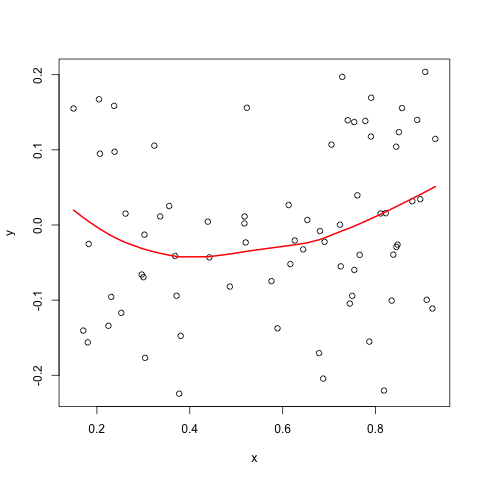

In [37]:
%%R

x <- merged_df[[factor]]
y <- merged_df[[2]]

# Fit the loess curve
loess_fit <- loess(y ~ x, span = 0.75, degree = 2)

# Plot the data and loess curve
plot(x, y)
lines(loess_fit$x, loess_fit$fitted, col = "red", lwd = 2)

In [38]:
%%R -o long_df

long_df <- merged_df %>%
  pivot_longer(cols = -ContinuousPseudoprogressionScore,
               names_to = "pathways",
               values_to = "activity.score")

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


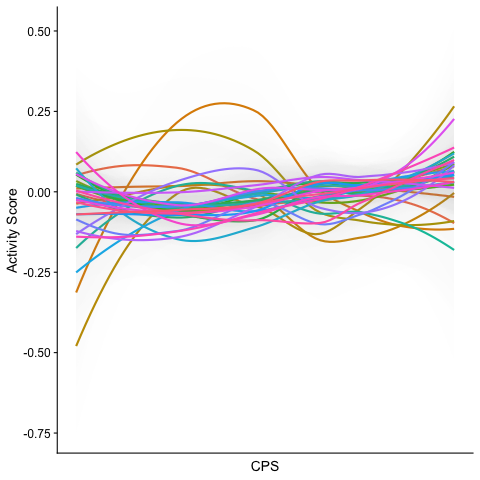

In [39]:
%%R

p1 <- ggplot(long_df, aes(x = .data[[factor]], y = activity.score, color=pathways)) +
  #geom_point() +
  geom_smooth(alpha = 0.01,) +
  #scale_color_manual(values=mod_colors)+
  xlab('CPS') +
  ylab('Activity Score') +
  theme(
    axis.ticks.x = element_blank(),
    axis.text.x = element_blank()
  ) +
  NoLegend()


p1

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


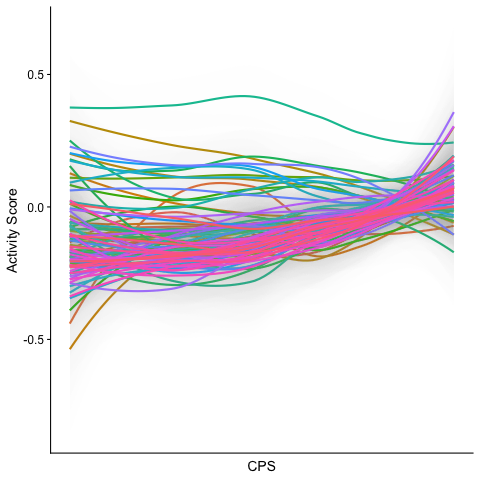

In [49]:
%%R

p1 <- ggplot(long_df, aes(x = .data[[factor]], y = activity.score, color=pathways)) +
  #geom_point() +
  geom_smooth(alpha = 0.01,) +
  #scale_color_manual(values=mod_colors)+
  xlab('CPS') +
  ylab('Activity Score') +
  theme(
    axis.ticks.x = element_blank(),
    axis.text.x = element_blank()
  ) +
  NoLegend()


p1

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


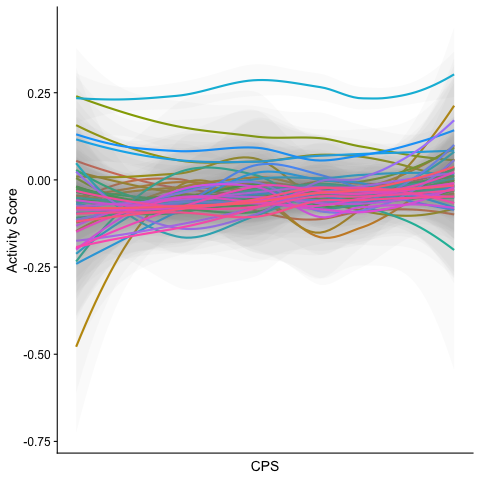

In [33]:
%%R

p1 <- ggplot(long_df, aes(x = .data[[factor]], y = activity.score, color=pathways)) +
  #geom_point() +
  geom_smooth(alpha = 0.04,) +
  #scale_color_manual(values=mod_colors)+
  xlab('CPS') +
  ylab('Activity Score') +
  theme(
    axis.ticks.x = element_blank(),
    axis.text.x = element_blank()
  ) +
  NoLegend()


p1

In [56]:
temp = all_data['low_removed_galea']['fits_all'][cell_supertype]['CPS'][all_data['low_removed_galea']['fits_all'][cell_supertype]['CPS']['adj.P.Val']<0.01]
temp.head()

,Row.names,CPSearly,CPSlate,AgeatDeath,GenderMale,QC_Gene_unique_log,QC_MT.pct,AveExpr,F,P.Value,adj.P.Val,celltype,names,StdErr.CPSearly,StdErr.CPSlate,StdErr.AgeatDeath,StdErr.GenderMale,StdErr.QC_Gene_unique_log,StdErr.QC_MT.pct
1,Neurotransmission: Dopaminergic Synapses,-11.435263,-11.249755,-0.006251,-0.145211,0.850438,0.281646,-0.032827,16.124067,2.821292e-17,3.244486e-15,Microglia-PVM,Neurotransmission: Dopaminergic Synapses,2.366935,2.368279,0.105174,0.409349,0.630849,0.570934
2,General metabolism: General metabolism other,14.383306,14.365943,0.001463,-0.048391,-1.038656,-0.168678,0.020269,12.430097,3.040422e-13,1.748242e-11,Microglia-PVM,General metabolism: General metabolism other,2.366935,2.368279,0.105174,0.409349,0.630849,0.570934
3,Protein metabolism: Proteostasis,-8.491612,-8.452570,-0.002332,-0.011479,0.624603,0.014282,-0.005312,9.769506,2.684185e-10,1.028937e-08,Microglia-PVM,Protein metabolism: Proteostasis,2.366935,2.368279,0.105174,0.409349,0.630849,0.570934
4,Synaptic Plasticity: Synaptic Plasticity Other,-14.054766,-14.122527,0.002899,-0.024021,0.996029,0.230484,-0.005459,9.022340,1.818905e-09,5.229351e-08,Microglia-PVM,Synaptic Plasticity: Synaptic Plasticity Other,2.366935,2.368279,0.105174,0.409349,0.630849,0.570934
5,Miscellaneous: Immunity,15.028325,15.024701,-0.011996,0.066481,-1.010916,0.210701,0.027689,8.831525,2.965822e-09,6.821392e-08,Microglia-PVM,Miscellaneous: Immunity,2.366935,2.368279,0.105174,0.409349,0.630849,0.570934


In [55]:
temp = all_data['low_removed_galea']['fits_all'][cell_supertype]['late_vs_early']
temp

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,celltype,names
Neurotransmission: Dopaminergic Synapses,0.185508,0.074060,0.296957,-0.032827,3.268815,0.001140,0.131111,-0.974650,Microglia-PVM,Neurotransmission: Dopaminergic Synapses
Neurotransmission: Synaptic Vesicles,-0.118393,-0.201945,-0.034840,-0.002657,-2.782703,0.005556,0.319470,-2.290880,Microglia-PVM,Neurotransmission: Synaptic Vesicles
Gene expression: Translation,0.197016,0.039973,0.354059,-0.001355,2.463680,0.014024,0.354774,-3.042793,Microglia-PVM,Gene expression: Translation
Neurotransmission: Glutamatergic Synapses,-0.142181,-0.256822,-0.027540,-0.005943,-2.435597,0.015150,0.354774,-3.104702,Microglia-PVM,Neurotransmission: Glutamatergic Synapses
Synaptic Plasticity: Neuron Shape,-0.191929,-0.349716,-0.034141,0.002283,-2.388743,0.017206,0.354774,-3.206442,Microglia-PVM,Synaptic Plasticity: Neuron Shape
...,...,...,...,...,...,...,...,...,...,...
Gene expression: RNA processing,0.005214,-0.109937,0.120366,0.006723,0.088928,0.929168,0.959417,-5.784657,Microglia-PVM,Gene expression: RNA processing
Neural Development: Neurogenesis,0.007053,-0.161123,0.175229,-0.000261,0.082358,0.934389,0.959417,-5.785169,Microglia-PVM,Neural Development: Neurogenesis
Miscellaneous: Immunity,-0.003624,-0.147011,0.139763,0.027689,-0.049633,0.960431,0.977430,-5.787133,Microglia-PVM,Miscellaneous: Immunity
Gene Expression: RNA,-0.000563,-0.067152,0.066027,0.003856,-0.016596,0.986765,0.987915,-5.788128,Microglia-PVM,Gene Expression: RNA


In [189]:
def normalize_to_range(data, min_range, max_range):
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    scaled_data = min_range + (max_range - min_range) * normalized_data
    return scaled_data

In [190]:
temp.loc[:, 'Scaled.CPSlate'] = temp['CPSlate'] / temp['StdErr.CPSlate']
# temp.loc[:, 'Scaled.CPSlate'] = normalize_to_range(temp['Scaled.CPSlate'], -1, 1)

temp.loc[:, 'Scaled.CPSearly'] = temp['CPSearly'] / temp['StdErr.CPSearly']
# temp.loc[:, 'Scaled.CPSearly'] = normalize_to_range(temp['Scaled.CPSearly'], -1, 1)

/var/folders/70/42xwxjh94x5f164djlw1hwpc0000gv/T/ipykernel_42063/2107487297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.loc[:, 'Scaled.CPSlate'] = temp['CPSlate'] / temp['StdErr.CPSlate']
/var/folders/70/42xwxjh94x5f164djlw1hwpc0000gv/T/ipykernel_42063/2107487297.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.loc[:, 'Scaled.CPSearly'] = temp['CPSearly'] / temp['StdErr.CPSearly']


In [193]:
temp = all_data['low_removed_gabitto']['fits_all'][cell_supertype]['CPS'][all_data['low_removed_gabitto']['fits_all'][cell_supertype]['CPS']['adj.P.Val']<0.01]


,Row.names,CPSearly,CPSlate,AgeatDeath,GenderMale,QC_Gene_unique_log,QC_MT.pct,AveExpr,F,P.Value,adj.P.Val,celltype,names,StdErr.CPSearly,StdErr.CPSlate,StdErr.AgeatDeath,StdErr.GenderMale,StdErr.QC_Gene_unique_log,StdErr.QC_MT.pct
1,Transcription factors-GCM,9.207608,9.205424,-0.000398,-0.006699,-0.639103,-0.026943,0.296677,165.176368,2.725702e-124,3.052787e-122,Microglia-PVM,Transcription factors-GCM,2.355838,2.357161,0.10602,0.412769,0.627628,0.571698
2,Transcription factors-DM,5.388253,5.403857,0.000574,0.017952,-0.374994,-0.001523,0.254505,57.123719,5.324009e-56,2.981445e-54,Microglia-PVM,Transcription factors-DM,2.355838,2.357161,0.10602,0.412769,0.627628,0.571698
3,Actin cytoskeleton,-1.509006,-1.483366,-0.001019,-0.021118,0.109762,0.127231,-0.033623,18.576040,6.864304e-20,2.562674e-18,Microglia-PVM,Actin cytoskeleton,2.355838,2.357161,0.10602,0.412769,0.627628,0.571698
4,Trafficking adaptors,1.425767,1.452489,-0.002543,-0.031940,-0.090695,0.021934,-0.044854,17.242723,1.818830e-18,4.602203e-17,Microglia-PVM,Trafficking adaptors,2.355838,2.357161,0.10602,0.412769,0.627628,0.571698
5,Transcription factors-zf-C2H2,0.463508,0.511491,0.000597,-0.015565,-0.040453,-0.092939,-0.047208,17.193353,2.054555e-18,4.602203e-17,Microglia-PVM,Transcription factors-zf-C2H2,2.355838,2.357161,0.10602,0.412769,0.627628,0.571698
6,Transcription factors,0.240201,0.289470,-0.000062,-0.019110,-0.020910,-0.001424,-0.030162,15.475665,1.458835e-16,2.723159e-15,Microglia-PVM,Transcription factors,2.355838,2.357161,0.10602,0.412769,0.627628,0.571698
7,Ubiquitination,1.106485,1.161569,-0.001493,-0.022883,-0.076028,0.027157,-0.041200,13.200874,4.402718e-14,7.044349e-13,Microglia-PVM,Ubiquitination,2.355838,2.357161,0.10602,0.412769,0.627628,0.571698
8,Phosphorylation,-0.130533,-0.102313,-0.000690,-0.044229,0.010197,0.023200,-0.043065,11.828781,1.422769e-12,1.991876e-11,Microglia-PVM,Phosphorylation,2.355838,2.357161,0.10602,0.412769,0.627628,0.571698
9,Neuropeptides,6.563710,6.479363,-0.002922,0.025215,-0.441597,-0.060712,0.103204,11.410173,4.124801e-12,5.133086e-11,Microglia-PVM,Neuropeptides,2.355838,2.357161,0.10602,0.412769,0.627628,0.571698
10,Ubiquitination-E3-RING-Single,1.238350,1.311131,-0.000903,-0.025752,-0.089776,0.005868,-0.042254,10.037542,1.367418e-10,1.531509e-09,Microglia-PVM,Ubiquitination-E3-RING-Single,2.355838,2.357161,0.10602,0.412769,0.627628,0.571698


### **Save Aggregated Data, Filtered Gene Sets, and Expressed Genes**

In [ ]:
%%R -i cell_supertype

# save all the data
save_path <- paste0('../results/', save_prefix, '/pathway_analysis/', cell_group, '/')

if (!dir.exists(save_path)) {
  dir.create(save_path, recursive = TRUE)
}

print('saving filtered gene sets...')
saveRDS(pw_data, paste0(save_path, cell_type_column, '_', cell_supertype, '_filtered_genes_sets.rds'))
print('done.')

print('saving aggregated count data...')
saveRDS(summed_counts_per_celltype, paste0(save_path, cell_type_column, '_', cell_supertype, '_aggregated_counts.rds'))
print('done.')

print('saving expressed genes...')
saveRDS(expressed_genes_per_celltype, paste0(save_path, cell_type_column, '_', cell_supertype, '_expressed_genesrds'))
print('done.')

print('saving GSVA scores...')
saveRDS(gsva_scores, paste0(save_path, cell_type_column, '_', cell_supertype, '_gsva_scores.rds'))
print('done.')

print('saving Fit scores...')
saveRDS(all_data, paste0(save_path, cell_type_column, '_', cell_supertype, '_pathway_scores.rds'))
print('done.')

[1] "saving filtered gene sets..."
[1] "done."
[1] "saving aggregated count data..."
[1] "done."
[1] "saving expressed genes..."
[1] "done."
[1] "saving GSVA scores..."
[1] "done."
[1] "saving Fit scores..."
[1] "done."


In [ ]:
all_data['fits_all'][cell_supertype]['CPS']

,CPSearly,CPSlate,AgeatDeath,GenderMale,QC_Gene_unique_log,QC_MT.pct,AveExpr,F,P.Value,adj.P.Val,celltype,names
protein dephosphorylation (GO:0006470),-0.472587,-0.354351,-0.004068,-0.063300,0.049106,0.133743,-0.044391,28.098391,4.852596e-31,2.536452e-27,Astrocyte,protein dephosphorylation (GO:0006470)
ephrin receptor signaling pathway (GO:0048013),0.275227,0.388969,-0.005616,-0.037937,0.003579,0.249860,-0.046451,26.931448,8.974784e-30,2.345560e-26,Astrocyte,ephrin receptor signaling pathway (GO:0048013)
regulation of axonogenesis (GO:0050770),2.342774,2.442601,-0.002109,-0.037480,-0.166345,0.358000,-0.043719,26.516152,2.544053e-29,4.432589e-26,Astrocyte,regulation of axonogenesis (GO:0050770)
neuron projection morphogenesis (GO:0048812),2.345986,2.393471,-0.004772,-0.037645,-0.144524,0.180404,-0.044949,25.952597,1.049285e-28,1.140525e-25,Astrocyte,neuron projection morphogenesis (GO:0048812)
positive regulation of cell projection organization (GO:0031346),1.750204,1.806499,-0.003054,-0.032205,-0.114348,0.238800,-0.043456,25.937113,1.090994e-28,1.140525e-25,Astrocyte,positive regulation of cell projection organiz...
...,...,...,...,...,...,...,...,...,...,...,...,...
"positive regulation of Wnt signaling pathway, planar cell polarity pathway (GO:2000096)",-1.046442,-1.072714,-0.001032,-0.000680,0.081545,0.037695,-0.002282,0.098919,9.964905e-01,9.972536e-01,Astrocyte,"positive regulation of Wnt signaling pathway, ..."
axon ensheathment in central nervous system (GO:0032291),0.444608,0.452474,-0.001024,-0.015937,-0.026104,0.001641,-0.054952,0.093747,9.969780e-01,9.975505e-01,Astrocyte,axon ensheathment in central nervous system (G...
glucose-6-phosphate transport (GO:0015760),-0.807018,-0.770637,0.000410,0.009044,0.052504,0.047913,-0.026948,0.079266,9.981132e-01,9.984953e-01,Astrocyte,glucose-6-phosphate transport (GO:0015760)
neurotransmitter reuptake (GO:0098810),-0.665475,-0.659547,-0.000399,0.000857,0.048793,-0.016097,-0.001049,0.072383,9.985410e-01,9.987321e-01,Astrocyte,neurotransmitter reuptake (GO:0098810)


### **Jack Kniffing**

Jack-knifing is a resampling technique in which we repeat the analysis on a subset of samples to assess the robustness of the observed patterns. If results are driven by outlier samples, we expect to see a bimodal or multi-modal pattern when we jack-knife the analysis. `This technique is most useful when we dealing with large datasets with +10 controls and +10 experiment conditions.`

We can perform jack-knife analysis at two levels:

- `Leave-one-out-validation (LOOV)`: In this type of analysis, we iteratively exclude one subject/donor from the analysis and examine the p-value distribution of the genes.

- `50% resampling:` In this analysis, iterating 100 times, we randomly select 50% of donors from the cohort and repeat the analysis to see if the logFC pattern of genes remain the same or change. The number of iterations that the logFC remain same as the full cohort provide a measure of robustness on the patterns

Below we perform jack-knifing to assess the robustness of the DE patterns.

In [ ]:
# %%R

# myJKloov_arrangeFn = function(inputList) {

#     # Extract the column name containing p-values
#     pval_colname = colnames(inputList[[1]])[grepl("P\\.Value", colnames(inputList[[1]]))]
    
#     # Extract the column name containing log-fold changes
#     logFC_colname = colnames(inputList[[1]])[grepl("logFC", colnames(inputList[[1]]))]

#     # Calculate z-scores for each data frame in the input list
#     for (i in 1:length(inputList)) {
#         inputList[[i]]$zscore = qnorm(inputList[[i]][, pval_colname]/2, lower.tail = FALSE) * sign(inputList[[i]][, logFC_colname])
#     }
    
#     # Initialize the result data frame with the pathway and zscore columns from the first data frame
#     res = inputList[[1]][, c("name", "zscore")]

#     # Merge the zscore columns from the remaining data frames based on the "pathway" column
#     for (i in 2:length(inputList)) {
#         res = suppressWarnings(merge(res, inputList[[i]][, c("name", "zscore")], by = "pathway"))
#     }

#     # Calculate the maximum p-value for each pathway across all data frames
#     res_max_pval = apply(res[,-1], 1, function(x) {
#         y = table(sign(x))
#         y = y[order(as.numeric(y), decreasing = TRUE)]
#         y = names(y)[1]
#         x = pnorm(abs(x), lower.tail = FALSE) * 2
#         x[sign(x) != y] = 1
#         return(max(x))
#     })

#     # Create a data frame with pathway and corresponding maximum p-value
#     res_max_pval = data.frame(pathway = res[, 1], max_pval = as.numeric(res_max_pval), stringsAsFactors = FALSE)

#     # Return the result data frame
#     return(res_max_pval)
# }



# myJK50pct_arrangeFn = function(inputList) {

#     # Extract the column name containing log-fold changes
#     logFC_colname = colnames(inputList[[1]])[grepl("logFC", colnames(inputList[[1]]))]

#     # Initialize the result data frame with the "pathway" and log-fold change columns from the first data frame
#     res = inputList[[1]][, c("pathway", logFC_colname)]

#     # Merge the log-fold change columns from the remaining data frames based on the "gene" column
#     for (i in 2:length(inputList)) {
#         res = suppressWarnings(merge(res, inputList[[i]][, c("pathway", logFC_colname)], by = "pathway"))
#     }

#     # Calculate concordance scores for each gene
#     res_concordance_score = lapply(1:nrow(res), function(i) {
#         x = as.numeric(res[i, -1])
#         y = table(sign(x))/length(x)
#         y = y[order(as.numeric(y), decreasing = TRUE)]

#         return(data.frame(gene = res[i, 1], pattern = names(y)[1], score = y[1], jk_count = length(x), stringsAsFactors = FALSE))
#     })

#     # Combine the individual concordance score data frames into a single data frame
#     res_concordance_score = do.call("rbind", res_concordance_score)

#     # Return the result data frame with concordance scores
#     return(res_concordance_score)
# }


In [ ]:
# %%R -o res_list_ad


# ########### Setting the parameters ################
# jack_knifing = TRUE

# if (jack_knifing){

#     res_w_jk <- list()
    
#     for(cell_type in names(summed_counts_per_celltype)){
        
#         summary <- list()
#         tmp_data <- list()
    
#         res_list_early=list()
#         res_list_late=list()
#         res_list_ad=list()
#         res_list_lve=list()

#         for(isbj in unique(colData(summed_counts_per_celltype[[cell_type]])[, subject_id])){
#             meta <- colData(summed_counts_per_celltype[[cell_type]])
#             meta <- meta[meta[, subject_id]!=isbj, ]
#             print('done')

#             meta[, random_effect] <- as.factor(meta[, random_effect])
#             summary[[cell_type]] <- meta

#             tmp_data[[cell_type]] <- gsva_scores[[cell_type]][colnames(gsva_scores[[cell_type]]) %in% as.vector(rownames(summary[[cell_type]]))]
                     

#             # get linear model fits
#             print('getting linear model fits...')
#             fits = get_fits(tmp_data, summary, covariates, random_effect)

            
#             # get matrix of scores for heatmap
#             print('get matrix of scores')
#             temp_res = get_scores(fits)
                                            
#             if(isbj %in% unique(meta[, subject_id][meta$pathology.group %in% c("no", "early")])){
#                 res_list_early = c(res_list_early, list(tmp_res[['all']][[cell_type]][['early_vs_no']][, c("names", "logFC", "P.Value")]))
#             }
#             if(isbj %in% unique(meta[, subject_id][meta$pathology.group %in% c("no", "late")])){
#                 res_list_late = c(res_list_late, list(tmp_res[['all']][[cell_type]][['late_vs_no']][, c("names", "logFC", "P.Value")]))
#             }
#             if(isbj %in% unique(meta[, subject_id][meta$pathology.group %in% c("no", "late", "early")])){
#                 res_list_ad = c(res_list_ad, list(tmp_res[['all']][[cell_type]][['ad_vs_no']][, c("names", "logFC", "P.Value")]))
#             }
#             if(isbj %in% unique(meta[, subject_id][meta$pathology.group %in% c("late", "early")])){
#                 res_list_lve = c(res_list_lve, list(tmp_res[['all']][[cell_type]][['late_vs_early']][, c("names", "logFC", "P.Value")]))
#             } 
#         }

#         # res_jk_early=myJKloov_arrangeFn(inputList=res_list_early)
#         # colnames(res_jk_early)[2]=paste0("jk_early.",colnames(res_jk_early)[2])
        
#         # res_jk_late=myJKloov_arrangeFn(inputList=res_list_late)
#         # colnames(res_jk_late)[2]=paste0("jk_late.",colnames(res_jk_late)[2])
        
#         # res_jk_ad=myJKloov_arrangeFn(inputList=res_list_ad)
#         # colnames(res_jk_ad)[2]=paste0("jk_ad.",colnames(res_jk_ad)[2])

#         # res_jk_lve=myJKloov_arrangeFn(inputList=res_list_lve)
#         # colnames(res_jk_lve)[2]=paste0("jk_lve.",colnames(res_jk_lve)[2])

#         # res_jk=merge(res_jk_early, res_jk_late, by="pathway")
#         # res_jk=merge(res_jk, res_jk_ad, by='pathway')
#         # res_jk=merge(res_jk, res_lve, by='pathway')
                    
#         # res_jk$jk_early_partial_fdr=p.adjust(res_jk$k_early.max_pval[res_jk$early.adj.P.Val<0.1],method="BH")
#         # res_jk$jk_late_partial_fdr=p.adjust(res_jk$k_late.max_pval[res_jk$late.adj.P.Val<0.1],method="BH")
#         # res_jk$jk_ad_partial_fdr=p.adjust(res_jk$k_ad.max_pval[res_jk$ad.adj.P.Val<0.1],method="BH")
#         # res_jk$jk_lve_partial_fdr=p.adjust(res_jk$k_lve.max_pval[res_jk$lve.adj.P.Val<0.1],method="BH")

#         # res_w_jk=c(res_w_jk, list(merge(DE_results, res_jk, by="pathway")))
                                            
#         # rm(res_jk, res_jk_early, res_jk_late, res_jk_ad, res_jk_lve, res_list_early, res_list_late, res_list_ad, res_list_lve)
        
#     }
# } else {
#     print('Number of unique subjects <= 10 or `jack_knifing` param set to `FALSE`....')
#     print('Warning.....')
#     print('Skipping Jack Knifing')
#     res_w_jk <- NULL
# }


[1] "done"
[1] "getting linear model fits..."


[1] "get matrix of scores"
[1] "done"
[1] "getting linear model fits..."
[1] "get matrix of scores"
[1] "done"
[1] "getting linear model fits..."

Error in get(as.character(FUN), mode = "function", envir = envir) : 
  object 'as.SimpleList' of mode 'function' was not found


RInterpreterError: Failed to parse and evaluate line '\n\n########### Setting the parameters ################\njack_knifing = TRUE\n\nif (jack_knifing){\n\n    res_w_jk <- list()\n    \n    for(cell_type in names(summed_counts_per_celltype)){\n        \n        summary <- list()\n        tmp_data <- list()\n    \n        res_list_early=list()\n        res_list_late=list()\n        res_list_ad=list()\n        res_list_lve=list()\n\n        for(isbj in unique(colData(summed_counts_per_celltype[[cell_type]])[, subject_id])){\n            meta <- colData(summed_counts_per_celltype[[cell_type]])\n            meta <- meta[meta[, subject_id]!=isbj, ]\n            print(\'done\')\n\n            meta[, random_effect] <- as.factor(meta[, random_effect])\n            summary[[cell_type]] <- meta\n\n            tmp_data[[cell_type]] <- gsva_scores[[cell_type]][colnames(gsva_scores[[cell_type]]) %in% as.vector(rownames(summary[[cell_type]]))]\n                     \n\n            # get linear model fits\n            print(\'getting linear model fits...\')\n            fits = get_fits(tmp_data, summary, covariates, random_effect)\n\n            \n            # get matrix of scores for heatmap\n            print(\'get matrix of scores\')\n            temp_res = get_scores(fits)\n                                            \n            if(isbj %in% unique(meta[, subject_id][meta$pathology.group %in% c("no", "early")])){\n                res_list_early = c(res_list_early, list(tmp_res[[\'all\']][[cell_type]][[\'early_vs_no\']][, c("names", "logFC", "P.Value")]))\n            }\n            if(isbj %in% unique(meta[, subject_id][meta$pathology.group %in% c("no", "late")])){\n                res_list_late = c(res_list_late, list(tmp_res[[\'all\']][[cell_type]][[\'late_vs_no\']][, c("names", "logFC", "P.Value")]))\n            }\n            if(isbj %in% unique(meta[, subject_id][meta$pathology.group %in% c("no", "late", "early")])){\n                res_list_ad = c(res_list_ad, list(tmp_res[[\'all\']][[cell_type]][[\'ad_vs_no\']][, c("names", "logFC", "P.Value")]))\n            }\n            if(isbj %in% unique(meta[, subject_id][meta$pathology.group %in% c("late", "early")])){\n                res_list_lve = c(res_list_lve, list(tmp_res[[\'all\']][[cell_type]][[\'late_vs_early\']][, c("names", "logFC", "P.Value")]))\n            } \n        }\n\n        # res_jk_early=myJKloov_arrangeFn(inputList=res_list_early)\n        # colnames(res_jk_early)[2]=paste0("jk_early.",colnames(res_jk_early)[2])\n        \n        # res_jk_late=myJKloov_arrangeFn(inputList=res_list_late)\n        # colnames(res_jk_late)[2]=paste0("jk_late.",colnames(res_jk_late)[2])\n        \n        # res_jk_ad=myJKloov_arrangeFn(inputList=res_list_ad)\n        # colnames(res_jk_ad)[2]=paste0("jk_ad.",colnames(res_jk_ad)[2])\n\n        # res_jk_lve=myJKloov_arrangeFn(inputList=res_list_lve)\n        # colnames(res_jk_lve)[2]=paste0("jk_lve.",colnames(res_jk_lve)[2])\n\n        # res_jk=merge(res_jk_early, res_jk_late, by="pathway")\n        # res_jk=merge(res_jk, res_jk_ad, by=\'pathway\')\n        # res_jk=merge(res_jk, res_lve, by=\'pathway\')\n                    \n        # res_jk$jk_early_partial_fdr=p.adjust(res_jk$k_early.max_pval[res_jk$early.adj.P.Val<0.1],method="BH")\n        # res_jk$jk_late_partial_fdr=p.adjust(res_jk$k_late.max_pval[res_jk$late.adj.P.Val<0.1],method="BH")\n        # res_jk$jk_ad_partial_fdr=p.adjust(res_jk$k_ad.max_pval[res_jk$ad.adj.P.Val<0.1],method="BH")\n        # res_jk$jk_lve_partial_fdr=p.adjust(res_jk$k_lve.max_pval[res_jk$lve.adj.P.Val<0.1],method="BH")\n\n        # res_w_jk=c(res_w_jk, list(merge(DE_results, res_jk, by="pathway")))\n                                            \n        # rm(res_jk, res_jk_early, res_jk_late, res_jk_ad, res_jk_lve, res_list_early, res_list_late, res_list_ad, res_list_lve)\n        \n    }\n} else {\n    print(\'Number of unique subjects <= 10 or `jack_knifing` param set to `FALSE`....\')\n    print(\'Warning.....\')\n    print(\'Skipping Jack Knifing\')\n    res_w_jk <- NULL\n}\n'.
R error message: 'Error in get(as.character(FUN), mode = "function", envir = envir) : \n  object \'as.SimpleList\' of mode \'function\' was not found'

In [ ]:
# valid_pathways = {}
# all_pathways = {}

# for test_name in test_names:
#     valid_pathways[test_name] = {}
#     all_pathways[test_name] = pd.DataFrame()
#     # Loop through each unique cell type in the cell_type column of adata_annot and filter statistically significant pathways
#     for cell_type in celltypes:
#         try:
#             # Create a dataframe for the current cell type from a matrix in all_data, rename and set index.
#             valid_pathways[test_name][cell_type] = pd.DataFrame(all_data['scores_filtered'][test_name][cell_type])
#             all_data['scores_all'][test_name]['all'][cell_type].index.name = 'pathway'
#             valid_pathways[test_name][cell_type].index.name = 'pathway'
#             valid_pathways[test_name][cell_type].rename(columns={cell_type: 'score_adj'}, inplace=True)

#             # Merge current cell type dataframe with its corresponding scores_all dataframe on "pathway" and remove missing rows
#             valid_pathways[test_name][cell_type] = valid_pathways[test_name][cell_type].merge(all_data['scores_all'][test_name]['all'][cell_type],
#                                                      how='outer', on='pathway')
#             valid_pathways[test_name][cell_type].dropna(axis=0, inplace=True)

#             # Filter rows with P.Value less than 0.05 from the current cell type dataframe and sort by P.Value    
#             # valid_pathways[test_name][cell_type] = valid_pathways[test_name][cell_type][valid_pathways[test_name][cell_type]['P.Value']<0.05]
#             valid_pathways[test_name][cell_type].sort_values(by='P.Value', inplace=True)
            
#             # Append the current cell type's dataframe to the all_pathways dataframe and sort by pathway
#             all_pathways[test_name] = pd.concat([all_pathways[test_name], valid_pathways[test_name][cell_type]], axis=0)
#             all_pathways[test_name].sort_values(by='pathway', inplace=True)
#         except KeyError:
#             continue

### Renaming convention

In [ ]:
# # Read in a CSV file containing the renaming convention for pathway names
# # Remove duplicate names in the renaming convention dataframe
# renaming_convention = pd.read_csv('../data/pathway_databases/renaming_convention.csv', dtype=str)
# renaming_convention.drop_duplicates(subset='names', inplace=True)

# for test_name in test_names:
#     # Reset the index of the all_pathways dataframe to allow merging with renamed convention
#     all_pathways[test_name].reset_index(inplace=True)
#     all_pathways[test_name] = pd.merge(all_pathways[test_name], renaming_convention[['names', 'shortened', 'highlight']], how='left', on='names')
#     all_pathways[test_name].set_index(keys='pathway', inplace=True)
#     all_pathways[test_name] =  all_pathways[test_name].astype(object).replace(np.nan, 'None')


#     dat_dir = f'../results/{test_name}/{save_prefix}/Data/'

#     if not os.path.exists(dat_dir):
#         os.makedirs(dat_dir)

#     # Write the all_pathways dataframe to a CSV file
#     all_pathways[test_name].to_csv(dat_dir+f'differentially_expressed_pathways.csv')

### Preliminary Heat Map Visualization

Plot Select Cell-type-specific Pathways

In [ ]:
# for test_name in test_names:
#     print(f'heatmap for select cell-type-specific pathways in {test_name} test')
#     list_of_paths_to_annotate = list(all_pathways[test_name].shortened[all_pathways[test_name].highlight=='yes'])
#     df = all_pathways[test_name][all_pathways[test_name]['P.Value']<0.05]

#     fig_dir = f'../results/{test_name}/{save_prefix}/HeatMap/'
#     if not os.path.exists(fig_dir):
#         os.makedirs(fig_dir)
        
#     save_path = fig_dir+'_cell_type_specific_diff_exp_paths.pdf'

#     pathway_analyses.plot_and_select_top_deps(df, list_of_paths_to_annotate, save_prefix=save_prefix,
#                          save_path=save_path, filter=True, cell_type_specific=True, 
#                          test_name=test_name, cell_types=celltypes)

Plot Select Shared Pathways

In [ ]:
# for test_name in test_names:
#     print(f'heatmap for select shared pathways in {test_name} test')
#     list_of_paths_to_annotate = list(all_pathways[test_name].shortened[all_pathways[test_name].highlight=='yes'])
#     df = all_pathways[test_name][all_pathways[test_name]['P.Value']<0.05]


#     fig_dir = f'../results/{test_name}/{save_prefix}/HeatMap/'
#     if not os.path.exists(fig_dir):
#         os.makedirs(fig_dir)
        
#     save_path = fig_dir+'filtered_broad_diff_exp_paths.pdf'

#     pathway_analyses.plot_and_select_top_deps(df, list_of_paths_to_annotate, save_prefix=save_prefix,
#                          save_path=save_path, filter=True, cell_type_specific=False, 
#                          test_name=test_name, cell_types=celltypes)


In [ ]:
# %%R -o meta_obj -o expressed_genes_per_celltype -o aggregated_gene_normed_counts_per_celltype

# if (pseudobulking_strategy == 'metacell'){

#   seurat_obj <- as.Seurat(adata_annot, counts = "counts")

#   print(seurat_obj)

#   # create a hdWGCNA experiment for each celltype
#   seurat_dat <- seurat_obj
#   aggregated_gene_normed_counts_per_celltype <- list()
#   expressed_genes_per_celltype <- list()

#   for (cur_cell_type in celltypes){

#     seurat_dat <- 
#     seurat_obj <- as.Seurat(adata_annot[olData(adata_annot)[, cell_type_column]==cur_cell_type], counts = 'counts')

#     print(paste0('Creating hdWGNA Experiment for ', toupper(cur_cell_type)))

#     if (gene_selection == 'custom') {
#       seurat_obj <- SetupForWGCNA(
#         seurat_obj,
#         gene_select = "custom",                                            # the gene selection approach
#         gene_list = as.vector(geneSet),    # list of genes to be included
#         group.by = cell_type_column,                                            # grouping parameter
#         wgcna_name = cur_cell_type                  # the name of the hdWGCNA experiment
#       )
#     } else {
#       seurat_obj <- SetupForWGCNA(
#         seurat_obj,
#         gene_select = "fraction",                               # the gene selection approach
#         fraction = gene_celltype_threshold,                     # fraction of cells for gene inclusion
#         group.by = cell_type_column',                                 # grouping parameter
#         wgcna_name = cur_cell_type       # the name of the hdWGCNA experiment
#       )
#     }

#     print(paste0('Constructing MetaCells in hdWGCNA Experiment for ', toupper(cur_cell_type)))
    
#     seurat_obj <- MetacellsByGroups(
#             seurat_obj = seurat_obj,
#             group.by = c(cell_type_column, subject_id), # specify the columns in seurat_obj@meta.data to group by
#             reduction = 'harmony',  # select the dimensionality reduction to perform KNN on
#             k = 25, # nearest-neighbors parameter
#             max_shared = 10, # maximum number of shared cells between two metacells
#             ident.group = cell_type_column, # set the Idents of the metacell seurat object
#             wgcna_name = cur_cell_type,        # the name of the hdWGCNA experiment
#             )

#     # normalize metacell expression matrix:
#     seurat_obj  <- NormalizeMetacells(seurat_obj, wgcna_name = toupper(substr(cur_cell_type, 1, 3)))

#     aggregated_gene_normed_counts_per_celltype[[cur_cell_type]] <- as.SingleCellExperiment(GetMetacellObject(seurat_obj,
#                                                       wgcna_name = toupper(substr(cur_cell_type, 1, 3))))   

#     expressed_genes_per_celltype[[cur_cell_type]] <- GetWGCNAGenes(seurat_obj)                                       
#   }

#   rm(seurat_obj)
#   rm(seurat_dat)
#   rm(adata_annot)
# } else {
#   aggregated_gene_normed_counts_per_celltype <- NULL
#   expressed_genes_per_celltype <- NULL
# }


In [ ]:
# %%R -i metadata

# conflicts_prefer(dplyr::rename)
# conflicts_prefer(dplyr::select)


# dat_dir <- paste0("../results/", save_prefix, "/general/")

# if (!dir.exists(dat_dir)) {
#     dir.create(dat_dir, recursive = TRUE)
# }

# summary <- read.csv(metadata, check.names = FALSE)

# result_df <- lapply(names(avs_by_ind_out), function(cell_type) {
#   cell_df <- avs_by_ind_out[[cell_type]]
#   merged_df <- merge(t(cell_df), summary, by.x = 0, by.y = subject_id, all.x = TRUE)
#   percentages <- prop.table(table(merged_df$pathology.group))

#   data.frame(
#     category = names(percentages),
#     cell_type = rep(cell_type, length(percentages)),
#     percentage = as.numeric(percentages)
#   )
# }) %>% bind_rows()

# result_df <- result_df %>% 
#             pivot_wider(names_from = cell_type, values_from = percentage) %>%
#             pivot_longer(cols = !category, names_to = "cell_type", values_to = "percentage")

# no_reorder <- result_df %>% 
#   ggplot(aes(x = cell_type, y = percentage)) +
#   geom_bar(stat = "identity", aes(fill = category)) +
#   scale_fill_manual(values = brewer.pal(8, "Set2")) +
#   labs(x = "Cell Types", y = "Fraction", fill = "Pathology Group") +  # Rename X and Y-axis labels
#   scale_x_discrete(labels = result_df$cell_type) +  # Include corresponding cell types on X-ticks
#   theme_classic() +
#   theme(axis.text.x = element_blank()) +
#   theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Adjust X-axis text angle for better visibility

# no_reorder

# ggsave(paste0(dat_dir, "cell_type_composition_stacked_bars.svg"), height = 4, width = 6, bg = "white")
